In [1]:
import pandas as pd
import numpy as np
import astropy.utils.data
from astropy.coordinates import SkyCoord,concatenate
import astropy.units as u
import datetime as _datetime
from astropy.io import fits as _fits
from astropy.coordinates import FK5,ICRS
from astropy.io import ascii
from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time

# Join sources from 200219 and 191213 together

## Load in sources for 200219 and 191213

In [2]:
df_200219=pd.read_csv('200219_results.csv')
df_191213=pd.read_csv('191213g_results.csv')
final_results=pd.concat([df_200219,df_191213], axis=0)
final_results=final_results.reset_index(drop=True)

print('Number of sources for S200219m : ', len(df_200219) )
print('Number of sources for S191213g : ', len(df_191213) )

print('Total number of sources : ', len(final_results))

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2,3,4,5,6,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of sources for S200219m :  42075
Number of sources for S191213g :  2716
Total number of sources :  44791


## Save PS1, GLADE and all sources to csvs for crossmatching

In [3]:
final_results_ps1=final_results[final_results['source']=='PS1']
final_results_glade=final_results[(final_results['source']=='GLADE') & (final_results['flag1']!='Q')]

final_results_ps1[['our_id','RA','Dec']].to_csv('ps1_sources_for_gaia.csv')
final_results_glade[['our_id','RA','Dec']].to_csv('glade_sources_for_gaia.csv')
print('GLADE sources : ', len(final_results_glade))
print('PS sources : ', len(final_results_ps1))

GLADE sources :  3920
PS sources :  40331


## Rename columns to avoid multiple 'RA', 'Dec' columns

In [4]:

final_results['ra_glade']=final_results['RA'][final_results['source']=='GLADE']
final_results['dec_glade']=final_results['Dec'][final_results['source']=='GLADE']
#final_results.rename(columns={'RA':'ra_glade'}, inplace=True)
#final_results.rename(columns={'Dec':'dec_glade'}, inplace=True)
final_results.rename(columns={'RA':'ra_overall'}, inplace=True)
final_results.rename(columns={'Dec':'dec_overall'}, inplace=True)
# final_results = final_results.drop('RA', 1)
# final_results = final_results.drop('Dec', 1)

## Add in the xmatch between GLADE and PS1

In [5]:
glade_ps1_crossmatch=pd.read_csv('gladecheck1arsecnew4_Lana_S.csv')

glade_ps1_crossmatch.rename(columns={'RA':'ra_glade'}, inplace=True)
glade_ps1_crossmatch.rename(columns={'DEC':'dec_glade'}, inplace=True)
glade_ps1_crossmatch.rename(columns={'ObjID':'objID'}, inplace=True)

### Only take closest crossmatched source

In [6]:
def sep(ra,dec,ra1,dec1):
    c1=SkyCoord(ra*u.deg, dec*u.deg)
    c2=SkyCoord(ra1*u.deg, dec1*u.deg)
    sep = c1.separation(c2)
    return sep.arcsecond

glade_ps1_crossmatch['separation']=np.abs(sep(glade_ps1_crossmatch['ra_glade'].values,glade_ps1_crossmatch['dec_glade'].values,glade_ps1_crossmatch['raMean'].values,glade_ps1_crossmatch['decMean'].values))
glade_ps1_crossmatch=glade_ps1_crossmatch.sort_values('separation').drop_duplicates(subset='our_id', keep='first')

In [7]:
print('GLADE xmatch with PS : ', len(glade_ps1_crossmatch))

GLADE xmatch with PS :  4387


### Combine with sources table to get PS columns for GLADE xmatched sources

In [8]:
# merge PS1 and glade crossmatch columns
#final_results = final_results.merge(glade_ps1_crossmatch, how = 'outer', on = ['our_id', 'our_id'])

df1 = final_results.set_index(["our_id"])
df2 = glade_ps1_crossmatch.set_index(["our_id"])

final_results = df1.combine_first(df2).reset_index()
#final_results=pd.concat([final_results,glade_ps1_crossmatch])
print(len(final_results))

44791


In [9]:
dupes=final_results[final_results.duplicated(['objNameHMS'], keep = False)]
# print(dupes[['objNameHMS', 'source','raMean', 'ra_glade', 'decMean', 'dec_glade', 'our_id']][dupes['objNameHMS']=='PSX J164230.97-035959.8'])
# print(len(dupes[dupes['source']=='PS1']))

In [10]:
sorts=final_results.sort_values(by='source', ascending=True)
final_results=sorts.drop_duplicates(subset='objNameHMS', keep='first')
# print(len(final_results))
# print(final_results[['objNameHMS', 'source','raMean', 'ra_glade', 'decMean', 'dec_glade', 'our_id']][final_results['objNameHMS']=='PSX J164230.97-035959.8'])

final_results[['our_id','source','ra_overall','dec_overall']].to_csv('all_sources_for_gaia.csv')

# Add Gaia DR3 xmatch

In [11]:
#xmatch_ps1_only=pd.read_csv('gaia_ps1_xmatch_result.csv')
xmatch_all=pd.read_csv('all_xmatch_dr3_4.csv')

xmatch_all.rename(columns={'ra':'ra_xmatch'}, inplace=True)
xmatch_all.rename(columns={'dec':'dec_xmatch'}, inplace=True)

xmatch_all.rename(columns={'ra.1':'ra_gaia'}, inplace=True)
xmatch_all.rename(columns={'dec.1':'dec_gaia'}, inplace=True)


df1 = xmatch_all.set_index(["our_id"])
df2 = final_results.set_index(["our_id"])

xmatch_all = df1.combine_first(df2).reset_index()

In [12]:
print('Number of sources xmatched in Gaia :' , len(xmatch_all))

Number of sources xmatched in Gaia : 43827


# If there are duplicate Gaia crossmatches, only take closest one

In [13]:
def sep(ra,dec,ra1,dec1):
    c1=SkyCoord(ra*u.deg, dec*u.deg)
    c2=SkyCoord(ra1*u.deg, dec1*u.deg)
    sep = c1.separation(c2)
    return sep.arcsecond

xmatch_all['separation']=np.abs(sep(xmatch_all['ra_gaia'].values,xmatch_all['dec_gaia'].values,xmatch_all['ra_xmatch'].values,xmatch_all['dec_xmatch'].values))
xmatch_all=xmatch_all.sort_values('separation').drop_duplicates(subset='our_id', keep='first')

## Cut out GLADE QSOs (flag=Q)

In [14]:
xmatch_all=xmatch_all[xmatch_all['flag1']!='Q']
print('Number of closest sources xmatched in Gaia :' , len(xmatch_all))

Number of closest sources xmatched in Gaia : 41596


# Make a cut on astrometric error and proper motion for PS1 sources only

In [15]:
# UWE = https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf
# xmatch_all['uwe']=np.sqrt(xmatch_all['astrometric_chi2_al']/(xmatch_all['astrometric_n_good_obs_al']-5))
# print('Min and Max astrometric error', np.nanmin(xmatch_all['uwe']), np.nanmax(xmatch_all['uwe']))
xmatch_all['pm_total']=np.sqrt(xmatch_all['pmra']**2+xmatch_all['pmdec']**2)
xmatch_all['pm_total_sq']=xmatch_all['pmra']**2+xmatch_all['pmdec']**2
xmatch_all['pm_sig']=np.sqrt(((xmatch_all['pmra']**2)*(xmatch_all['pmra_error']**2))+((xmatch_all['pmdec']**2)*(xmatch_all['pmdec_error']**2)))
xmatch_all['pm_total_error']=np.sqrt(xmatch_all['pmra_error']**2+xmatch_all['pmdec_error']**2)

xmatch_all['pm_frac_error'] = xmatch_all['pm_total']/xmatch_all['pm_total_error']
#xmatch_all['pm_sigma'] = np.sqrt((xmatch_all['pmra']/xmatch_all['pmra_error'])**2+(xmatch_all['pmdec']/xmatch_all['pmdec_error'])**2)

print('Mean astrometric error and proper motion',np.mean(xmatch_all['astrometric_excess_noise']),np.mean(xmatch_all['pmra']))

Mean astrometric error and proper motion 8.661022824424796 -2.242623172310704


In [16]:
xmatch_ps1_only=xmatch_all[xmatch_all['source']=='PS1']
xmatch_GLADE_only=xmatch_all[xmatch_all['source']=='GLADE']
print('PS1 sources to analyse : ', len(xmatch_ps1_only))
print('GLADE sources : ', len(xmatch_GLADE_only))

#xmatch_cut_1=xmatch_ps1_only[((xmatch_ps1_only['astrometric_excess_noise_sig']>2)  & (xmatch_ps1_only['astrometric_excess_noise']>1) | ((xmatch_ps1_only['ruwe']<1.4) | (xmatch_ps1_only['ruwe'].isna())) | (xmatch_ps1_only['astrometric_excess_noise_sig']<=2)) | (xmatch_ps1_only['astrometric_excess_noise'].isna()) ]
xmatch_cut_1=xmatch_ps1_only[ ((xmatch_ps1_only['ruwe']>1.4) | (xmatch_ps1_only['ruwe'].isna())) ]
#xmatch_cut_1=xmatch_ps1_only[ ((xmatch_ps1_only['ipd_gof_harmonic_amplitude']>0.1) | (xmatch_ps1_only['ipd_gof_harmonic_amplitude'].isna())) ]

xmatch_cut=xmatch_cut_1[(xmatch_ps1_only['pm_total_sq']<3*(xmatch_ps1_only['pm_sig'])) | (xmatch_ps1_only['pm_total_sq'].isna())]

print('Number of PS sources cut', len(xmatch_ps1_only)-len(xmatch_cut))
print('Number of PS sources not cut', len(xmatch_cut))
#print(xmatch_cut[['raMean','decMean','pmra','pmdec','pm_sig','astrometric_excess_noise_sig','astrometric_excess_noise', 'ruwe','source']])

#xmatch_cut_out=xmatch_ps1_only[((xmatch_ps1_only['astrometric_excess_noise_sig']>2) & (xmatch_ps1_only['astrometric_excess_noise']<1) ) | (xmatch_ps1_only['ruwe']>1.4)]

xmatch_cut_out=xmatch_ps1_only[ ((xmatch_ps1_only['ruwe']<1.4)) ]
#xmatch_cut_out=xmatch_ps1_only[ ((xmatch_ps1_only['ipd_gof_harmonic_amplitude']<0.1)) ]

xmatch_cut_out_2=xmatch_ps1_only[(xmatch_ps1_only['pm_total_sq']>3*(xmatch_ps1_only['pm_sig']))]

#print(xmatch_cut_out[['raMean','decMean','pmra','pmdec','pm_sig','astrometric_excess_noise_sig','astrometric_excess_noise', 'ruwe','source']])
 #& ((xmatch_ps1_only['ruwe']>3) | (xmatch_ps1_only['ruwe'].isna()))

PS1 sources to analyse :  37810
GLADE sources :  3786
Number of PS sources cut 20603
Number of PS sources not cut 17207


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [17]:
print('Cut by the astrometric error : ',len(xmatch_cut_out))
print('Cut by the proper motion : ', len(xmatch_cut_out_2))

Cut by the astrometric error :  19004
Cut by the proper motion :  20343


In [18]:

# #ipd_cuts=xmatch_ps1_only[['ipd_gof_harmonic_amplitude','raMean','decMean', 'source','ruwe']][(xmatch_ps1_only['ipd_gof_harmonic_amplitude']>0.1) & (xmatch_ps1_only['ruwe']>1.4)]
# ipd_cuts=xmatch_ps1_only[['ipd_gof_harmonic_amplitude','raMean','decMean', 'source','ruwe']][(xmatch_ps1_only['ipd_gof_harmonic_amplitude']>0.1)]

# # plt.hist(ipd_cuts['ruwe'], bins=100)
# # plt.xlim(0.9,10)
# # plt.show()

# print(ipd_cuts[['ipd_gof_harmonic_amplitude','raMean','decMean', 'source','ruwe']])

# size = 90
# pylab.rcParams.update({'font.size':12})
# #pylab.figure(1,(12,12))

# nrow = 4
# ncol = 4

# plt.figure(figsize = (8,8))
# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

# for i in range(16):
#    # i = i + 1 # grid spec indexes from 0
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     cim = getcolorim(ipd_cuts['raMean'].values[i+16],ipd_cuts['decMean'].values[i+16],size=size,filters="grz")

#     ax1.imshow(cim,origin="upper")
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')

In [19]:
from __future__ import print_function
import numpy
from astropy.table import Table
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import pylab
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

# Show a selection of the ones cut by the astrometric error

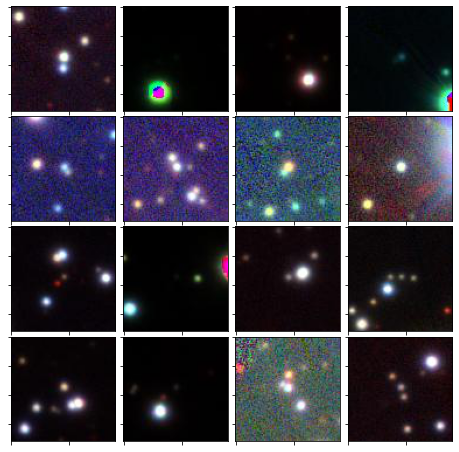

In [20]:
import matplotlib.gridspec as gridspec
%matplotlib inline
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(xmatch_cut_out['raMean'].values[i],xmatch_cut_out['decMean'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
plt.savefig('removed_by_noise.pdf')

# Show a selection of the ones cut by proper motion

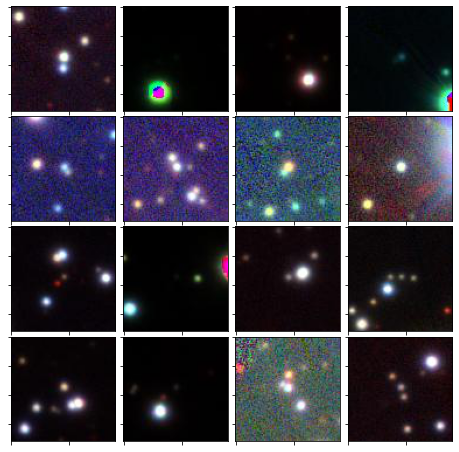

In [21]:
import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(xmatch_cut_out_2['raMean'].values[i],xmatch_cut_out_2['decMean'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
plt.savefig('removed_by_proper_motion.pdf')

# Show a selection of high noise, kept ones

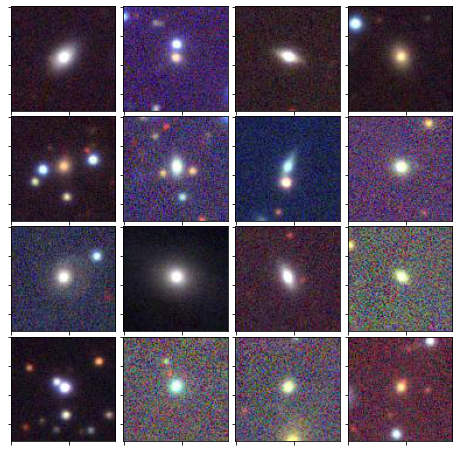

In [22]:
xmatch_cut_1_low_noise=xmatch_cut[(xmatch_cut['ruwe']>2)]
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(xmatch_cut_1_low_noise['raMean'].values[i],xmatch_cut_1_low_noise['decMean'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

# Recombine 'good' Gaia sources with GLADE sources

### i.e. keep GLADE sources no matter what the errors

In [23]:
xmatch_glade_ps1_cut=pd.concat([xmatch_cut,xmatch_GLADE_only], axis=0)
print('Number of PS sources not cut, plus all GLADE sources : ', len(xmatch_glade_ps1_cut))

Number of PS sources not cut, plus all GLADE sources :  20993


In [24]:
total_cut_df = xmatch_glade_ps1_cut
print('Number of sources without duplicate xmatches', len(total_cut_df))

Number of sources without duplicate xmatches 20993


# Load the template FITS

In [25]:
template_hdulist = _fits.open('WS2021A1-003_CatalogueTemplate.fits')
template_primary_hdu = template_hdulist[0]
template_hdu = template_hdulist[1]
template_column_names = [col.name for col in template_hdu.columns]
print(template_column_names)


['CNAME', 'TARGSRVY', 'TARGPROG', 'TARGCAT', 'TARGID', 'TARGNAME', 'TARGPRIO', 'TARGUSE', 'TARGCLASS', 'PROGTEMP', 'OBSTEMP', 'GAIA_ID', 'GAIA_DR', 'GAIA_RA', 'GAIA_DEC', 'GAIA_EPOCH', 'GAIA_PMRA', 'GAIA_PMRA_ERR', 'GAIA_PMDEC', 'GAIA_PMDEC_ERR', 'GAIA_PARAL', 'GAIA_PARAL_ERR', 'HEALPIX', 'IFU_SPAXEL', 'IFU_PA', 'IFU_DITHER', 'MAG_G', 'MAG_G_ERR', 'MAG_R', 'MAG_R_ERR', 'MAG_I', 'MAG_I_ERR', 'GAIA_MAG_G', 'GAIA_MAG_G_ERR', 'GAIA_MAG_BP', 'GAIA_MAG_BP_ERR', 'GAIA_MAG_RP', 'GAIA_MAG_RP_ERR', 'APS_WL_MIN', 'APS_WL_MAX', 'APS_Z', 'APS_SIGMA', 'APS_TEMPL_LIB', 'APS_TEMPL_LIB_NORM', 'APS_PPXF_WL_MIN', 'APS_PPXF_WL_MAX', 'APS_PPXF_MOM', 'APS_PPXF_DEG_ADD', 'APS_PPXF_DEG_MULT', 'APS_PPXF_NUM_MC', 'APS_GAND_MODE', 'APS_GAND_ERR', 'APS_GAND_RED1', 'APS_GAND_RED2', 'APS_GAND_EBV', 'APS_LS_MODE', 'APS_LS_RES', 'APS_LS_NUM_MC', 'APS_SSP_NUM_WLKR', 'APS_SSP_NUM_CHAIN', 'APS_IFU_MASK', 'APS_IFU_TSSL_TYPE', 'APS_IFU_TSSL_TARG_SNR', 'APS_IFU_TSSL_MIN_SNR', 'APS_IFU_TSSL_COVAR', 'APS_IFU_SRC_ID', 'APS_IF

## Extension 0 Header

In [26]:
ext0_header=template_hdulist[0].header

#Set the catalogue submitter and CCs
ext0_header['CAT_NME1']='Lana'
ext0_header['CAT_NME2']='Salmon'
ext0_header['CAT_MAIL']='lana.salmon@ucdconnect.ie'
ext0_header['CAT_CC']='p.jonker@sron.nl,morgan.fraser@ucd.ie,lorraine.hanlon@ucd.ie,antonio.martin-carrillo@ucd.ie'
print(repr(ext0_header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT WS2021A1-003 Catalogue Template                                         
DATAMVER= '8.00    '           / WEAVE Data Model Version                       
TRIMESTE= '2021A1  '           / Observing Trimester                            
MAG_G_CM= '' / Survey specific mag column(s) used for MAG_G                     
MAG_R_CM= '' / Survey specific mag column(s) used for MAG_R                     
MAG_I_CM= '' / Survey specific mag column(s) used for MAG_I                     
STL_NME1= 'Peter   '                                                            
STL_NME2= 'Jonker  '                                                            
STL_MAIL= 'p.jonker@sron.nl'

## Extension 1 Header

In [27]:
ext1_header=template_hdulist[1].header
print(repr(ext1_header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1136 / length of dimension 1                          
NAXIS2  =                    0 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  113 / number of table fields                         
EXTNAME = 'WS2021A1-003 CATALOGUE' / extension name                             
TTYPE1  = 'CNAME   '           / WEAVE object name from coordinates             
TFORM1  = '20A     '           / data format of field: ASCII Character          
TDISP1  = 'A20     '           / Display format for column                      
TUCD1   = 'meta.id;meta.main

## Calculate Gaia mag errors

In [28]:
# according to dr2 https://www.cosmos.esa.int/documents/29201/1773953/Gaia+DR2+primer+version+1.3.pdf/a4459741-6732-7a98-1406-a1bea243df79?t=1581668739161
total_cut_df['phot_g_mean_mag_err']=1.086/total_cut_df['phot_g_mean_flux_over_error']
total_cut_df['phot_bp_mean_mag_err']=1.086/total_cut_df['phot_bp_mean_flux_over_error']
total_cut_df['phot_rp_mean_mag_err']=1.086/total_cut_df['phot_rp_mean_flux_over_error']

In [29]:
def GLADE_ID(df):
    df["GLADE_ID"] = df["HyperLEDA"].fillna(df["GWGC"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["PGC"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["SDSS"])
    df["GLADE_ID"] = df["GLADE_ID"].fillna(df["2MASS"])
    
GLADE_ID(total_cut_df)

## Take relevant columns from our catalogue

In [30]:
total_cut_df = total_cut_df.reset_index(drop=True)
FITS_table_from_cat=total_cut_df[['source','our_id','designation','ra_gaia', 'dec_gaia', 'pmra', 'pmra_error',
                                  'pmdec', 'pmdec_error','parallax', 'parallax_error','phot_g_mean_mag',
                                  'phot_g_mean_mag_err','phot_bp_mean_mag','phot_bp_mean_mag_err',
                                  'phot_rp_mean_mag','phot_rp_mean_mag_err', 'gMeanKronMag', 'gMeanKronMagErr',
                                  'rMeanKronMag', 'rMeanKronMagErr','iMeanKronMag', 'iMeanKronMagErr',
                                  'objNameHMS', 'raMean', 'decMean',
                                  'gMeanKronMag', 'gMeanKronMagErr','iMeanKronMag', 'iMeanKronMagErr',
                                  'rMeanKronMag', 'rMeanKronMagErr','yMeanKronMag', 'yMeanKronMagErr','zMeanKronMag', 'zMeanKronMagErr',
                                  'ra_glade', 'dec_glade', 'GLADE_ID', 'Hmag', 'e_Hmag','Jmag', 'e_Jmag',  'Kmag', 'eKmag',
                                  'ra_glade', 'dec_glade', 'GLADE_ID','Bmag', 'e_Bmag'
                                ]]


FITS_table_from_cat.columns = ['COORDCAT','TARGID','GAIA_ID','GAIA_RA', 'GAIA_DEC', 'GAIA_PMRA', 'GAIA_PMRA_ERR', 
                               'GAIA_PMDEC', 'GAIA_PMDEC_ERR', 'GAIA_PARAL', 'GAIA_PARAL_ERR','GAIA_MAG_G', 
                               'GAIA_MAG_G_ERR', 'GAIA_MAG_BP', 'GAIA_MAG_BP_ERR', 
                               'GAIA_MAG_RP', 'GAIA_MAG_RP_ERR', 'MAG_G', 'MAG_G_ERR', 
                               'MAG_R', 'MAG_R_ERR', 'MAG_I', 'MAG_I_ERR',
                               'PS_ID', 'PS_RA', 'PS_DEC',
                               'PS_MAG_G', 'PS_MAG_G_ERR', 'PS_MAG_I', 'PS_MAG_I_ERR', 
                               'PS_MAG_R', 'PS_MAG_R_ERR', 'PS_MAG_Y', 'PS_MAG_Y_ERR', 'PS_MAG_Z', 'PS_MAG_Z_ERR',
                                'NIRCAT_RA',  'NIRCAT_DEC',  'NIRCAT_ID', 'NIRCAT_MAG_H', 'NIRCAT_MAG_H_ERR', 
                               'NIRCAT_MAG_J', 'NIRCAT_MAG_J_ERR', 'NIRCAT_MAG_K', 'NIRCAT_MAG_K_ERR',
                               'OPTCAT_RA', 'OPTCAT_DEC',   'OPTCAT_ID', 'OPTCAT_MAG_B', 'OPTCAT_MAG_B_ERR'
                              ]

FITS_table_from_cat.reset_index()
#survey identifier
FITS_table_from_cat['TARGSRVY']='WS2021A1-003'

#CNAME is set by WEAVE
FITS_table_from_cat['CNAME']=''

#optional personal name for programme/catalogue
FITS_table_from_cat['TARGPROG']='GW-galaxy'
FITS_table_from_cat['TARGCAT']='WS2021A1-003.fits'

#T for target, GALAXY
FITS_table_from_cat['TARGUSE']='T'
FITS_table_from_cat['TARGCLASS']='GALAXY'

# PROGTEMP for MOS LR 3x1020s 60min OB
FITS_table_from_cat['PROGTEMP']='11331'

#OBSTEMP for max airmass=1.8, moon dist=90 deg, 
#max sky brightness=20.5, max seeing = 1.3'', transparency=0.8
FITS_table_from_cat['OBSTEMP']='GAEAD'

#TARGNAME is the same as unique id
FITS_table_from_cat['TARGNAME']=FITS_table_from_cat['TARGID']

#TARGPRIO = 10.0 for GLADE galaxies
#For the rest, set according to 
FITS_table_from_cat['TARGPRIO']=float(10)

    
def DR (df):
    if df['source'] == 'GLADE' :
        return 'V2'
    else:
        return ''
def glade (df):
    if df['source'] == 'GLADE' :
        return 'GLADE'
    else:
        return ''
    
def gaia (df):
    if df['GAIA_ID']!='':
        return '3'
    else:
        return ''

def PS (df):
    if df['PS_ID']!='':
        return '2'
    else:
        return ''
    
# ID columns are strings
FITS_table_from_cat['GAIA_ID']=FITS_table_from_cat['GAIA_ID'].astype(str)
FITS_table_from_cat['PS_ID']=FITS_table_from_cat['PS_ID'].astype(str)
FITS_table_from_cat['OPTCAT_ID']=FITS_table_from_cat['OPTCAT_ID'].astype(str)
FITS_table_from_cat['NIRCAT_ID']=FITS_table_from_cat['NIRCAT_ID'].astype(str)

# Null values for ID columns should be empty strings
FITS_table_from_cat.loc[FITS_table_from_cat.GAIA_ID == 'nan', ['GAIA_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.NIRCAT_ID == 'nan', ['NIRCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.OPTCAT_ID == 'nan', ['OPTCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.PS_ID == 'nan', ['PS_ID']] = ''

# only give NIRCAT/OPTCAT columns for GLADE galaxies.
FITS_table_from_cat['NIRCAT_DR']=total_cut_df.apply (lambda total_cut_df: DR(total_cut_df), axis=1)
FITS_table_from_cat['OPTCAT_DR']=total_cut_df.apply (lambda total_cut_df: DR(total_cut_df), axis=1)
FITS_table_from_cat['NIRCAT']=total_cut_df.apply (lambda total_cut_df: glade(total_cut_df), axis=1)
FITS_table_from_cat['OPTCAT']=total_cut_df.apply (lambda total_cut_df: glade(total_cut_df), axis=1)

#Only give Gaia/PS columns for sources crossmatched with either.
#FITS_table_from_cat['GAIA_DR']=FITS_table_from_cat.apply (lambda FITS_table_from_cat: gaia(FITS_table_from_cat), axis=1)
FITS_table_from_cat['PS_DR']=FITS_table_from_cat.apply (lambda FITS_table_from_cat: PS(FITS_table_from_cat), axis=1)
FITS_table_from_cat['GAIA_DR']='3'
FITS_table_from_cat['GAIA_EPOCH']=2016.0  
# PS nulls are -999 - set to nan
FITS_table_from_cat=FITS_table_from_cat.replace(-999.000000, np.nan)


# Set APS / IFU columns to the default by setting them to null

FITS_table_from_cat['APS_PPXF_MOM']=-1
FITS_table_from_cat['APS_FLAG'] =''
FITS_table_from_cat['IFU_SPAXEL']=''
FITS_table_from_cat['APS_Z']=np.nan
FITS_table_from_cat['APS_TEMPL_LIB']=''
FITS_table_from_cat['APS_GAND_EBV']=-1
FITS_table_from_cat['APS_GAND_ERR']=-1
FITS_table_from_cat['APS_TEMPL_LIB_NORM']=-1
FITS_table_from_cat['APS_IFU_TSSL_MIN_SNR'] =np.nan
FITS_table_from_cat['IFU_PA'] =np.nan
FITS_table_from_cat['IFU_DITHER'] =float(0)
FITS_table_from_cat['APS_WL_MIN'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_TYPE'] =''
FITS_table_from_cat['GENCAT_INFO'] =''
FITS_table_from_cat['APS_SSP_NUM_WLKR'] =-1
FITS_table_from_cat['APS_LS_NUM_MC'] =-1
FITS_table_from_cat['APS_PPXF_DEG_MULT'] =-1
FITS_table_from_cat['APS_GAND_MODE'] =-1
FITS_table_from_cat['APS_GAND_RED2'] =np.nan
FITS_table_from_cat['APS_PPXF_NUM_MC'] =-1
FITS_table_from_cat['APS_IFU_SRC_DEC']=np.nan
FITS_table_from_cat['APS_IFU_SRC_ID'] =''
FITS_table_from_cat['APS_LS_RES'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_COVAR'] =-1
FITS_table_from_cat['APS_SSP_NUM_CHAIN'] =-1
FITS_table_from_cat['HEALPIX'] =-1
FITS_table_from_cat['APS_LS_MODE'] =-1
FITS_table_from_cat['APS_WL_MAX'] =np.nan
FITS_table_from_cat['APS_IFU_MASK'] =-1
FITS_table_from_cat['APS_PPXF_DEG_ADD'] =-1
FITS_table_from_cat['APS_PPXF_WL_MAX'] =np.nan
FITS_table_from_cat['APS_IFU_TSSL_TARG_SNR'] =np.nan
FITS_table_from_cat['APS_GAND_RED1'] =np.nan
FITS_table_from_cat['APS_IFU_SRC_RA'] =np.nan
FITS_table_from_cat['APS_SIGMA'] =np.nan
FITS_table_from_cat['APS_PPXF_WL_MIN']=np.nan

# add spec or phot z from GLADE
def glade_spec_z (df):
    if df['flag2']==1:
        return df['z']
    else:
        return np.nan
    
def glade_phot_z (df):
    if df['flag2']==3:
        return df['z']
    else:
        return np.nan
    
FITS_table_from_cat['PHOTOZCAT_Z']=total_cut_df.apply (lambda total_cut_df: glade_phot_z(total_cut_df), axis=1)
FITS_table_from_cat['SPECZCAT_Z']=total_cut_df.apply (lambda total_cut_df: glade_spec_z(total_cut_df), axis=1)

FITS_table_from_cat['PHOTOZCAT_DR']= np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), 'V2','')
FITS_table_from_cat['SPECZCAT_DR']= np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), 'V2','')
FITS_table_from_cat['PHOTOZCAT']= np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), 'GLADE','')
FITS_table_from_cat['SPECZCAT']= np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), 'GLADE','')

FITS_table_from_cat['PHOTOZCAT_ID'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_ID,'')
FITS_table_from_cat['SPECZCAT_ID'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_ID,'')
FITS_table_from_cat['PHOTOZCAT_RA'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_RA,np.nan)
FITS_table_from_cat['SPECZCAT_RA'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_RA,np.nan)
FITS_table_from_cat['PHOTOZCAT_DEC'] = np.where(FITS_table_from_cat.PHOTOZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_DEC,np.nan)
FITS_table_from_cat['SPECZCAT_DEC'] = np.where(FITS_table_from_cat.SPECZCAT_Z.notnull(), FITS_table_from_cat.OPTCAT_DEC,np.nan)

FITS_table_from_cat['PHOTOZCAT_ID']=FITS_table_from_cat['PHOTOZCAT_ID'].astype(str)
FITS_table_from_cat['SPECZCAT_ID']=FITS_table_from_cat['SPECZCAT_ID'].astype(str)
FITS_table_from_cat.loc[FITS_table_from_cat.PHOTOZCAT_ID == 'nan', ['PHOTOZCAT_ID']] = ''
FITS_table_from_cat.loc[FITS_table_from_cat.SPECZCAT_ID == 'nan', ['SPECZCAT_ID']] = ''



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

# Set TARGPRIO based on magnitude and astrometric error

In [31]:
# check the magnitude of sources from PS1 and apply weights. If GLADE, set to 10.0.
# mags=FITS_table_from_cat['PS_MAG_R']
# minval= min(mags)
# maxval= max(mags)
# total_cut_df['normalized'] = (10-1)*(1.0-(mags-minval)/(maxval-minval))+1
# FITS_table_from_cat['TARGPRIO'] = np.where(FITS_table_from_cat.PS_ID!='', total_cut_df.normalized,float(10))
# FITS_table_from_cat.loc[FITS_table_from_cat.OPTCAT == 'GLADE', ['TARGPRIO']] = float(10)


FITS_table_from_cat['astrometric_excess_noise']=total_cut_df['astrometric_excess_noise']
FITS_table_from_cat['astrometric_excess_noise_sig']=total_cut_df['astrometric_excess_noise_sig']
FITS_table_from_cat['ruwe']=total_cut_df['ruwe']

mags=FITS_table_from_cat['PS_MAG_R'][FITS_table_from_cat['OPTCAT']=='']
minval= min(mags)
maxval= max(mags)

good_astro = FITS_table_from_cat[(FITS_table_from_cat['ruwe']<=2)]
mags_consid=good_astro['PS_MAG_R'][good_astro['OPTCAT']=='']
mags=good_astro['PS_MAG_R']
minval= np.nanmin(mags_consid)
maxval= np.nanmax(mags_consid)
good_astro['normalized']=(10-6)*(1.0-(mags-minval)/(maxval-minval))+6

bad_astro = FITS_table_from_cat[(FITS_table_from_cat['ruwe']>2)]
mags_consid=bad_astro['PS_MAG_R'][bad_astro['OPTCAT']=='']
mags=bad_astro['PS_MAG_R']
minval= np.nanmin(mags_consid)
maxval= np.nanmax(mags_consid)
bad_astro['normalized']=(6-1)*(1.0-(mags-minval)/(maxval-minval))+1

# no astro
no_astro = FITS_table_from_cat[(FITS_table_from_cat['ruwe'].isna())]
mags_consid=no_astro['PS_MAG_R'][no_astro['OPTCAT']=='']
mags=no_astro['PS_MAG_R']
minval= np.nanmin(mags_consid)
maxval= np.nanmax(mags_consid)
no_astro['normalized']=(10-1)*(1.0-(mags-minval)/(maxval-minval))+1

#print(len(good_astro),len(bad_astro))
overall_astro=pd.concat([good_astro,bad_astro], axis=0)
overall_astro=pd.concat([overall_astro,no_astro], axis=0)


overall_astro = overall_astro.set_index('TARGID')
overall_astro = overall_astro.reindex(index=FITS_table_from_cat['TARGID'])
overall_astro = overall_astro.reset_index()
#good astrometric error
#print(bad_astro[['uwe','normalized','rMeanKronMag','source']][good_astro['rMeanKronMag'].notna()])
FITS_table_from_cat['TARGPRIO'] = np.where(overall_astro.COORDCAT=='PS1', overall_astro.normalized,float(10))
FITS_table_from_cat.loc[FITS_table_from_cat.COORDCAT == 'GLADE', ['TARGPRIO']] = float(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

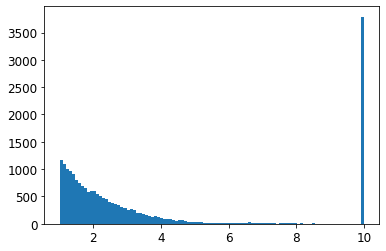

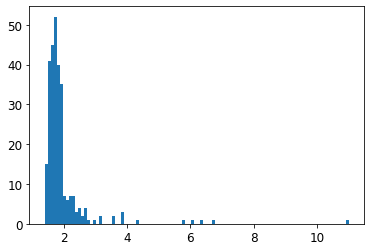

In [32]:
plt.figure(1)
plt.hist(FITS_table_from_cat['TARGPRIO'], bins=100)
plt.show()

plt.figure(2)
plt.hist(FITS_table_from_cat['ruwe'][FITS_table_from_cat['OPTCAT']==''], bins=100)
plt.show()

## If we don't have Gaia RA/Dec, transform PS1/GLADE to J2016 and put this into Gaia_RA, Gaia_dec columns

In [33]:
# Take PS or GLADE ra,dec,epoch
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5,ICRS
from astropy.io import ascii
# Read in decimal degree data, J2000 (FK5) coordinates
# ingest the coordinates
def precess(valra,valdec):
    c = SkyCoord(ra=valra, dec=valdec, unit='deg', frame='fk5')
    # print the coordinates
    # precess to J2015.5, i.e., Gaia reference system
    c_Gaia = c.transform_to(ICRS)
    # print the transformed coordinates
    ra=c_Gaia.ra.degree
    dec=c_Gaia.dec.degree
    return ra, dec


for t in range(0,len(FITS_table_from_cat)):
    if FITS_table_from_cat['GAIA_ID'][t]=='':
        if FITS_table_from_cat['PS_ID'][t]!='':
            #FITS_table_from_cat['GAIA_RA'][t]=FITS_table_from_cat['PS_RA'][t]
            #FITS_table_from_cat['GAIA_DEC'][t]=FITS_table_from_cat['PS_DEC'][t]
            FITS_table_from_cat['GAIA_RA'][t],  FITS_table_from_cat['GAIA_DEC'][t] = precess(FITS_table_from_cat['PS_RA'][t],FITS_table_from_cat['PS_DEC'][t])
            
            FITS_table_from_cat['GAIA_EPOCH'][t]=2016.0
        else:
            #FITS_table_from_cat['GAIA_RA'][t]=FITS_table_from_cat['OPTCAT_RA'][t]
            #FITS_table_from_cat['GAIA_DEC'][t]=FITS_table_from_cat['OPTCAT_DEC'][t]
            FITS_table_from_cat['GAIA_EPOCH'][t]=2016.0
            FITS_table_from_cat['GAIA_RA'][t],  FITS_table_from_cat['GAIA_DEC'][t] = precess(FITS_table_from_cat['OPTCAT_RA'][t],FITS_table_from_cat['OPTCAT_DEC'][t])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Fill in source of Mag G, Mag R, Mag I columns

In [34]:
# give a list of the columns where the Mag_GRI column came from. 
mag_source_g=[]
mag_source_r=[]
mag_source_i=[]

for t in range(0,len(total_cut_df)):
    if total_cut_df['source'][t]=='GLADE':
        mag_source_g.append('PS_MAG_G')
        mag_source_r.append('PS_MAG_R')
        mag_source_i.append('PS_MAG_I')
    else:
        mag_source_g.append('PS_MAG_G')
        mag_source_r.append('PS_MAG_R')
        mag_source_i.append('PS_MAG_I')

ext0_header['MAG_G_CM']='|'.join(mag_source_g)
ext0_header['MAG_R_CM']='|'.join(mag_source_r)
ext0_header['MAG_I_CM']='|'.join(mag_source_i)

# Study new dataframe

In [35]:
pd.set_option('display.max_columns', None)
FITS_table_from_cat=FITS_table_from_cat[template_column_names]

# put a cut of 1.0 on gaia_mag_bp_err as it seems to go above 1?

FITS_table_from_cat['GAIA_MAG_BP_ERR'][FITS_table_from_cat['GAIA_MAG_BP_ERR']>1]=np.nan
FITS_table_from_cat['GAIA_MAG_RP_ERR'][FITS_table_from_cat['GAIA_MAG_RP_ERR']>1]=np.nan
display(FITS_table_from_cat)

,CNAME,TARGSRVY,TARGPROG,TARGCAT,TARGID,TARGNAME,TARGPRIO,TARGUSE,TARGCLASS,PROGTEMP,OBSTEMP,GAIA_ID,GAIA_DR,GAIA_RA,GAIA_DEC,GAIA_EPOCH,GAIA_PMRA,GAIA_PMRA_ERR,GAIA_PMDEC,GAIA_PMDEC_ERR,GAIA_PARAL,GAIA_PARAL_ERR,HEALPIX,IFU_SPAXEL,IFU_PA,IFU_DITHER,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_I,MAG_I_ERR,GAIA_MAG_G,GAIA_MAG_G_ERR,GAIA_MAG_BP,GAIA_MAG_BP_ERR,GAIA_MAG_RP,GAIA_MAG_RP_ERR,APS_WL_MIN,APS_WL_MAX,APS_Z,APS_SIGMA,APS_TEMPL_LIB,APS_TEMPL_LIB_NORM,APS_PPXF_WL_MIN,APS_PPXF_WL_MAX,APS_PPXF_MOM,APS_PPXF_DEG_ADD,APS_PPXF_DEG_MULT,APS_PPXF_NUM_MC,APS_GAND_MODE,APS_GAND_ERR,APS_GAND_RED1,APS_GAND_RED2,APS_GAND_EBV,APS_LS_MODE,APS_LS_RES,APS_LS_NUM_MC,APS_SSP_NUM_WLKR,APS_SSP_NUM_CHAIN,APS_IFU_MASK,APS_IFU_TSSL_TYPE,APS_IFU_TSSL_TARG_SNR,APS_IFU_TSSL_MIN_SNR,APS_IFU_TSSL_COVAR,APS_IFU_SRC_ID,APS_IFU_SRC_RA,APS_IFU_SRC_DEC,APS_FLAG,NIRCAT,NIRCAT_DEC,NIRCAT_DR,NIRCAT_ID,NIRCAT_MAG_H,NIRCAT_MAG_H_ERR,NIRCAT_MAG_J,NIRCAT_MAG_J_ERR,NIRCAT_MAG_K,NIRCAT_MAG_K_ERR,NIRCAT_RA,OPTCAT,OPTCAT_DEC,OPTCAT_DR,OPTCAT_ID,OPTCAT_MAG_B,OPTCAT_MAG_B_ERR,OPTCAT_RA,PHOTOZCAT,PHOTOZCAT_DEC,PHOTOZCAT_DR,PHOTOZCAT_ID,PHOTOZCAT_RA,PHOTOZCAT_Z,PS_DEC,PS_DR,PS_ID,PS_MAG_G,PS_MAG_G_ERR,PS_MAG_I,PS_MAG_I_ERR,PS_MAG_R,PS_MAG_R_ERR,PS_MAG_Y,PS_MAG_Y_ERR,PS_MAG_Z,PS_MAG_Z_ERR,PS_RA,SPECZCAT,SPECZCAT_DEC,SPECZCAT_DR,SPECZCAT_ID,SPECZCAT_RA,SPECZCAT_Z
0,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_18586,200129_18586,6.748849,T,GALAXY,11331,GAEAD,Gaia EDR3 1856274767875388544,3,310.951228,27.135701,2016.0,3.233635,1.596984,-2.092881,1.630870,-2.894647,1.791958,-1,,NaN,0.0,19.905399,0.027082,18.744499,0.024533,18.143700,0.014096,20.580246,0.008635,19.738565,0.033888,17.907866,0.009629,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,27.135701,2,PSX J204348.29+270808.5,19.905399,0.027082,18.143700,0.014096,18.744499,0.024533,17.600201,0.048265,17.865299,0.024296,310.951228,,NaN,,,NaN,NaN
1,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_51639,200129_51639,3.540074,T,GALAXY,11331,GAEAD,Gaia EDR3 2692933297613690368,3,320.303899,3.642072,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,-1,,NaN,0.0,18.832001,0.016402,17.948099,0.019147,17.552900,0.017272,20.523312,0.020156,19.480413,0.069548,17.967350,0.053850,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,3.642071,2,PSX J212112.93+033831.4,18.832001,0.016402,17.552900,0.017272,17.948099,0.019147,17.296101,0.047388,17.327801,0.027071,320.303899,,NaN,,,NaN,NaN
2,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_31205,200129_31205,1.867313,T,GALAXY,11331,GAEAD,Gaia EDR3 1739923416621322880,3,318.412695,7.472724,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,-1,,NaN,0.0,20.328300,0.044363,18.970100,0.009949,18.373199,0.010787,20.799795,0.017202,20.138432,0.097290,18.326378,0.035215,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,7.472724,2,PSX J211339.04+072821.8,20.328300,0.044363,18.373199,0.010787,18.970100,0.009949,17.992001,0.052066,18.108900,0.015703,318.412695,,NaN,,,NaN,NaN
3,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_50796,200129_50796,6.905204,T,GALAXY,11331,GAEAD,Gaia EDR3 2691344980051777408,3,320.355916,1.428370,2016.0,2.014556,1.101776,0.583857,0.768176,-0.897398,1.163223,-1,,NaN,0.0,19.700300,0.012810,18.588301,0.013008,18.247601,0.011314,20.104237,0.006666,19.522875,0.041082,17.962906,0.015375,NaN,NaN,NaN,NaN,,-1,NaN,NaN,-1,-1,-1,-1,-1,-1,NaN,NaN,-1,-1,NaN,-1,-1,-1,-1,,NaN,NaN,-1,,NaN,NaN,,,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,,NaN,NaN,NaN,,NaN,,,NaN,NaN,1.428370,2,PSX J212125.41+012542.1,19.700300,0.012810,18.247601,0.011314,18.588301,0.013008,17.807501,0.039359,18.032600,0.041279,320.355916,,NaN,,,NaN,NaN
4,,WS2021A1-003,GW-galaxy,WS2021A1-003.fits,200129_40723,200129_40723,7.36146

## Final 191213g field

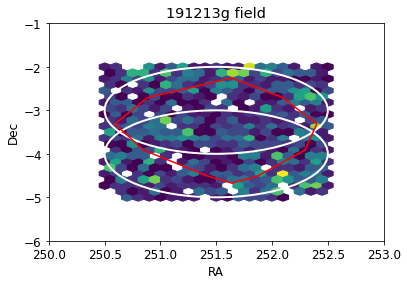

In [36]:
import lxml.etree
import healpy as hp
import astropy_healpix
import astropy.utils.data
from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from contours import contour_plots,join_0_360,split_contours,integrated_probability,hpix_contours
from skymapio import readskymap
from matplotlib.patches import Circle
payload = open('S191213g-4-Update.xml', 'rb').read()
root = lxml.etree.fromstring(payload)
params = {elem.attrib['name']:
              elem.attrib['value']
              for elem in root.iterfind('.//Param')}

graceid=params['GraceID']
prelim=params['AlertType']+params['Pkt_Ser_Num']

# Read the HEALPix sky map and the FITS header.
skymap, prob, distmu, distsigma, distnorm, npix, nside, distest, diststd = readskymap(params['skymap_fits'])

# Get the integrated probability map
csm=integrated_probability(prob)

# Identify the x% contours
contours=hpix_contours(csm,levels=[0.35],nest=False)
levels=[0.35]
levelsper=[35]

split_dec, split_ra = split_contours(contours, levels[0],0)
split_ra2, split_dec2=join_0_360(split_ra, split_dec)

plt.figure(1)

#plt.plot(FITS_table_from_cat['GAIA_RA'], FITS_table_from_cat['GAIA_DEC'],'r.',markersize=1)
plt.hexbin(FITS_table_from_cat['GAIA_RA'][FITS_table_from_cat['GAIA_RA']<253], FITS_table_from_cat['GAIA_DEC'][FITS_table_from_cat['GAIA_RA']<253],gridsize=20,mincnt=1)
for r in range(0,len(split_ra2)):
    plt.plot(split_ra2[r],split_dec2[r],'r-')
    
circ_ra=[251.5,251.5]
circ_dec=[-3, -4]

for k in range(0,len(circ_ra)):
    plt.gca().add_patch(Circle((circ_ra[k],circ_dec[k]),radius=1,linewidth=2,edgecolor='w',facecolor='none'))

plt.xlim(250, 253)
plt.ylim(-6,-1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('191213g field')
plt.savefig('191213_final.pdf')
plt.show()

In [37]:
print('Number of sources in field for S191213g : ', len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>250) & (FITS_table_from_cat['GAIA_RA']<253) & (FITS_table_from_cat['GAIA_DEC']>-6) & (FITS_table_from_cat['GAIA_DEC']<-1)]))

Number of sources in field for S191213g :  1773


## Final S200129m field

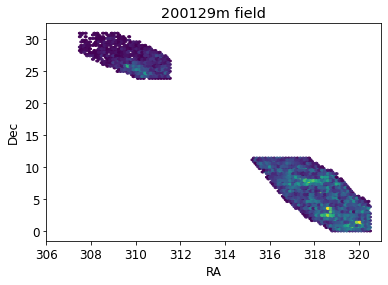

In [38]:
payload = open('S200129m-3-Initial.xml', 'rb').read()
root = lxml.etree.fromstring(payload)
params = {elem.attrib['name']:
              elem.attrib['value']
              for elem in root.iterfind('.//Param')}

graceid=params['GraceID']
prelim=params['AlertType']+params['Pkt_Ser_Num']

# Read the HEALPix sky map and the FITS header.
skymap, prob, distmu, distsigma, distnorm, npix, nside, distest, diststd = readskymap(params['skymap_fits'])

# Get the integrated probability map
csm=integrated_probability(prob)

# Identify the x% contours
contours=hpix_contours(csm,levels=[0.8],nest=False)
levels=[0.8]
levelsper=[80]

url='https://gracedb.ligo.org/api/superevents/'+graceid+'/files/LALInference.multiorder.fits'
skymap=read_sky_map(url, moc=True)

#separate masked array into separate contours
split_dec, split_ra = split_contours(contours, levels[0],0)
split_ra2, split_dec2=join_0_360(split_ra, split_dec)

plt.figure(1)

#plt.plot(FITS_table_from_cat['GAIA_RA'], FITS_table_from_cat['GAIA_DEC'],'r.',markersize=0.1)
plt.hexbin(FITS_table_from_cat['GAIA_RA'][FITS_table_from_cat['GAIA_RA']>253], FITS_table_from_cat['GAIA_DEC'][FITS_table_from_cat['GAIA_RA']>253],mincnt=1)
#for r in range(0,len(split_ra2)):
 #   plt.plot(split_ra2[r],split_dec2[r],'r-')

circ_dec=[29.612335710496843, 27.85185949195497, 26.2477161548889,  10.620983658324782, 8.805241967316647, 8.07878740033157, 7.047288229257127, 5.341596273782272, 6.483618852135471, 3.852372305991949, 2.7427172969132414, 4.2772558616878555, 5.270703402542033, 1.4219625799321136]
circ_ra=[308.6869806094183,309.2686980609418,310.21606648199446,316.7045393542275,316.9835320123155,318.31237072708615,316.95208020841557,317.21364174626984,318.50477619010024,317.83689902897294,319.01122602036787,319.43961474698034,318.955143285703,319.2376411147075]

#for k in range(0,len(circ_ra)):
#    plt.gca().add_patch(Circle((circ_ra[k],circ_dec[k]),radius=1,linewidth=2,edgecolor='w',facecolor='none'))

plt.xlim(306, 321)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('200129m field')
plt.savefig('200129_final.pdf')
plt.show()

In [39]:
print('Number of sources in field for top contour S200129m : ', len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['GAIA_RA']<312)]))
print('Number of sources in field for bottom contour S200129m : ', len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']>315)]))

Number of sources in field for top contour S200129m :  3157
Number of sources in field for bottom contour S200129m :  16063


In [40]:
len(FITS_table_from_cat[(FITS_table_from_cat['GAIA_RA']<315) & (FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['OPTCAT']!='GLADE')])

2753

In [41]:
print(FITS_table_from_cat[['GAIA_RA','GAIA_DEC','OPTCAT']][(FITS_table_from_cat['GAIA_RA']>315) & (FITS_table_from_cat['GAIA_ID']=='')])
print(FITS_table_from_cat[['GAIA_RA','GAIA_DEC','OPTCAT']][(FITS_table_from_cat['GAIA_RA']>315) & (FITS_table_from_cat['GAIA_ID']!='')])
print(FITS_table_from_cat[['GAIA_RA','GAIA_DEC','OPTCAT']][(FITS_table_from_cat['GAIA_RA']>315) & (FITS_table_from_cat['OPTCAT']!='')])

#17759 odd

          GAIA_RA   GAIA_DEC OPTCAT
9623   318.491669   6.015467       
9624   318.627011   6.020265       
9625   316.553002   6.009676       
9626   317.204582   6.075523       
9627   317.729413   6.021707       
...           ...        ...    ...
20988  317.013018  10.925166  GLADE
20989  317.472057  10.610733  GLADE
20990  319.213720   1.127835  GLADE
20991  319.182425   0.170635  GLADE
20992  319.254974   0.662742  GLADE

[9407 rows x 3 columns]
          GAIA_RA   GAIA_DEC OPTCAT
1      320.303899   3.642072       
2      318.412695   7.472724       
3      320.355916   1.428370       
4      318.743960   3.259430       
6      318.424693   3.292531       
...           ...        ...    ...
18843  319.564615   5.456457  GLADE
18844  318.192280   8.481474  GLADE
18845  319.433277   0.779891  GLADE
18846  319.772166   0.662012  GLADE
18847  318.125282  10.087936  GLADE

[6656 rows x 3 columns]
          GAIA_RA   GAIA_DEC OPTCAT
17207  319.634494   6.047041  GLADE
17208  320.245

In [42]:
print(FITS_table_from_cat[['GAIA_RA','GAIA_DEC']][(FITS_table_from_cat['GAIA_RA']<315) & (FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['GAIA_ID']=='')])
print(FITS_table_from_cat[['GAIA_RA','GAIA_DEC']][(FITS_table_from_cat['GAIA_RA']<315) & (FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['GAIA_ID']!='')])
print(FITS_table_from_cat[['GAIA_RA','GAIA_DEC']][(FITS_table_from_cat['GAIA_RA']<315) & (FITS_table_from_cat['GAIA_RA']>306) & (FITS_table_from_cat['OPTCAT']!='')])

          GAIA_RA   GAIA_DEC
8503   309.985190  27.956226
8504   309.857960  28.083753
8505   309.124730  27.941663
8506   309.693475  28.058480
8507   309.865038  28.104633
...           ...        ...
20981  311.021775  27.457182
20982  309.786024  29.212575
20983  309.960385  26.444084
20984  308.289170  30.441621
20985  309.497216  28.146546

[1406 rows x 2 columns]
          GAIA_RA   GAIA_DEC
0      310.951228  27.135701
9      310.826729  24.730428
11     309.979439  29.392583
24     310.928241  27.466892
46     309.103646  25.899571
...           ...        ...
18768  310.161095  25.618976
18777  310.408214  27.476433
18783  309.320842  30.657906
18818  308.983127  30.253599
18837  308.553410  27.584983

[1751 rows x 2 columns]
          GAIA_RA   GAIA_DEC
17210  311.127937  25.067491
17212  311.174808  24.322848
17218  310.446561  24.211768
17236  310.369157  24.388992
17238  311.176746  24.123127
...           ...        ...
20981  311.021775  27.457182
20982  309.786024  29.

# Populate FITS file with this dict

In [43]:
import datetime as _datetime

from astropy.io import fits as _fits


def populate_fits_table_template(fits_template, data_dict, output_filename,
                                 header, update_datetime=True,
                                 checksum=True, overwrite=False):
    """
    Populate a FITS table template with the provided data.

    Parameters
    ----------
    fits_template : list of str
        A FITS template with a primary HDU and a first extension with a table.
    data_dict : dict
        A dictionary with the data. Its keys should contain the name of the
        columns of the table in the first extension of the FITS template. Its
        values should be array-like with the data to populate the table.
    output_filename : str
        The name of the output file which will be created.
    primary_kwds : dict, optional
        A dictionary with a list of keywords and their corresponding values
        which will be written a in the primary header (updated or added).
    update_datetime : bool, optional
        Update DATETIME keyword in the output file.
    checksum : bool, optional
        Add CHECKSUM and DATASUM keywords in the output file.
    overwrite : bool, optional
        Overwrite the output FITS file.
    """
    
    # Read the FITS template
    
    template_hdulist = _fits.open(fits_template)
    template_primary_hdu = template_hdulist[0]
    template_hdu = template_hdulist[1]
    
    # Check that all the columns are available in the dictionary with the data
    
    template_column_names = [col.name for col in template_hdu.columns]
    
    for col_name in template_column_names:
        assert col_name in data_dict.keys()
    
    # Create list of columns as described in the template populated with the
    # provided data
    
    column_list = []

    for col in template_hdu.columns:
        
        column = _fits.Column(name=col.name, format=col.format,
                             disp=col.disp, unit=col.unit, null=col.null,
                             array=list(data_dict[col.name].values()))
        
        column_list.append(column)
    
    
    # Create a HDU from the column list
    
    coldefs = _fits.ColDefs(column_list)

    hdu = _fits.BinTableHDU.from_columns(coldefs)
    
    # Copy the header from the template
    
    hdu.header = template_hdu.header
    
    # Create the primary extension and populate it with the provided information
    
    primary_hdu = template_primary_hdu
    
    #for kwd in primary_kwds.keys():
     #   primary_hdu.header[kwd] = primary_kwds[kwd]
    primary_hdu = header
    # Update the keyword DATETIME if requested (and it exists)
    
    if (update_datetime is True) and ('DATETIME' in primary_hdu.keys()):
        datetime_str = _datetime.datetime.utcnow().strftime(
                           '%Y-%m-%d %H:%M:%S.%f')
        primary_hdu['DATETIME'] = datetime_str
    primary_hdu=_fits.PrimaryHDU(header=primary_hdu)
    # Create a HDU list and save it to a file
    
    hdulist = _fits.HDUList([primary_hdu, hdu])
    hdulist.writeto(output_filename, checksum=checksum, overwrite=overwrite)
    

In [44]:
data_dicts=FITS_table_from_cat.to_dict()
ext0_header['CAT_NME1']='Lana'
ext0_header['CAT_NME2']='Salmon'
ext0_header['CAT_MAIL']='lana.salmon@ucdconnect.ie'
ext0_header['CAT_CC']='p.jonker@sron.nl,morgan.fraser@ucd.ie,lorraine.hanlon@ucd.ie,antonio.martin-carrillo@ucd.ie'

ext0_header['MAG_G_CM']='PS_MAG_G'
ext0_header['MAG_R_CM']='PS_MAG_R'
ext0_header['MAG_I_CM']='PS_MAG_I'

prim_header=ext0_header
# A dictionary of the catalogue
# A dictionary of the keywords for primary extension
populate_fits_table_template('WS2021A1-003_CatalogueTemplate.fits', data_dicts, 'WS2021A1-003.fits',
                                 prim_header, update_datetime=True,
                                 checksum=True, overwrite=True)

# Show some PanSTARRS sources with highest priority

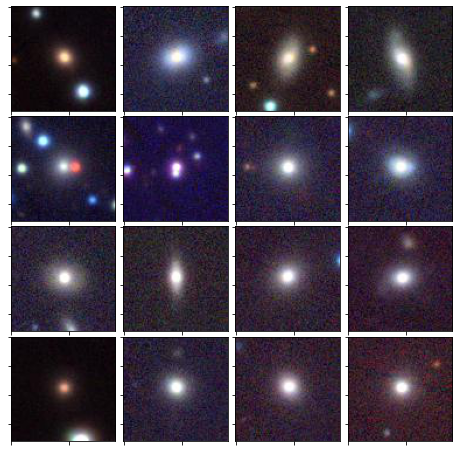

In [45]:
FITS_table_from_cat['ruwe']=total_cut_df['ruwe']
sorted_ps1=FITS_table_from_cat[(FITS_table_from_cat['OPTCAT']=='') & (FITS_table_from_cat['ruwe'].notna()) ].sort_values(by=['TARGPRIO'], ascending=False)

import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(sorted_ps1['GAIA_RA'].values[i+10],sorted_ps1['GAIA_DEC'].values[i+10],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
plt.savefig('PS_high_TARGPRIO.pdf')

# Show some PanSTARRS sources with lowest priority (with noise)

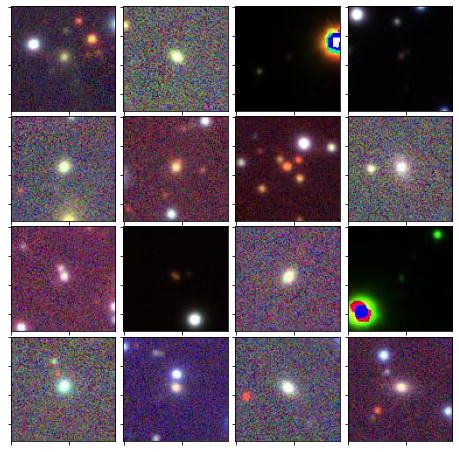

In [ ]:
sorted_ps1_6=FITS_table_from_cat[(FITS_table_from_cat['OPTCAT']=='') & (FITS_table_from_cat['ruwe'].notna()) ].sort_values(by=['TARGPRIO'])
import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(sorted_ps1_6['GAIA_RA'].values[i],sorted_ps1_6['GAIA_DEC'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
plt.savefig('PS_low_TARGPRIO.pdf')

# Show some GLADE sources

In [ ]:
sorted_glade=FITS_table_from_cat[FITS_table_from_cat['OPTCAT']!='']
import matplotlib.gridspec as gridspec
size = 90
pylab.rcParams.update({'font.size':12})
#pylab.figure(1,(12,12))

nrow = 4
ncol = 4

plt.figure(figsize = (8,8))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
   # i = i + 1 # grid spec indexes from 0

    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    cim = getcolorim(sorted_glade['GAIA_RA'].values[i],sorted_glade['GAIA_DEC'].values[i],size=size,filters="grz")

    ax1.imshow(cim,origin="upper")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

In [ ]:
print(len(FITS_table_from_cat[FITS_table_from_cat['GAIA_ID']!='']))

In [ ]:
FITS_table_from_cat['ipd_gof_harmonic_amplitude']=total_cut_df['ipd_gof_harmonic_amplitude']
sorted_glade=FITS_table_from_cat[FITS_table_from_cat['OPTCAT']!='']
print(FITS_table_from_cat[['ruwe','GAIA_RA','GAIA_DEC','OPTCAT']][FITS_table_from_cat['OPTCAT']=='GLADE'])

plt.hist(sorted_glade['ipd_gof_harmonic_amplitude'],bins=100)
plt.xlim(0,1)
plt.show()